### An encoding class for easy look up of the vocabularies.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
import itertools
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mwe_dataset import MWEDataset, Vocabulary, Mysubset, readfile
from mwe_classifier import MweClassifier
from mlp_baseline import MLP_baseline
import os
import rnn_dataset
import rnn_classifier
from crf import CRF
np.random.seed(42)

### Load the data
Conll reader reads the conllu file and Data loader gonna load the data and feed the encoded data to the model(either for training or inference).

In [2]:
#build train vocab
X_toks, Y_tags, deprels, toks_vocab, tags_vocab,deprel_vocab = readfile("corpus/train.conllu", update=True)

In [3]:
dist_tags = Counter(itertools.chain(*Y_tags))

[('B_I', 2), ('I_ET', 2), ('I_PONCT', 8), ('I_CL', 21), ('I_PRO', 25), ('I_A', 44), ('I_V', 48), ('B_PREF', 49), ('B_INTJ', 58), ('I_D', 74), ('I_C', 91), ('I_ADV', 105), ('B_ET', 117), ('I_P', 211), ('I_N', 229), ('B_X', 306), ('B_SYM', 329), ('B_PRO', 571), ('B_CL', 969), ('B_C', 1102), ('B_PART', 1198), ('B_SCONJ', 1769), ('B_A', 2170), ('B_V', 3916), ('B_PONCT', 4282), ('B_P', 5435), ('B_D', 5470), ('B_AUX', 5540), ('B_CONJ', 6234), ('B_NUM', 6527), ('B__', 7860), ('B_ADV', 9101), ('B_N', 9750), ('B_PRON', 11141), ('B_ADJ', 14014), ('B_PROPN', 19376), ('B_VERB', 22499), ('UNK', 23234), ('B_PUNCT', 27507), ('B_DET', 38204), ('B_ADP', 39805), ('B_NOUN', 46130)]


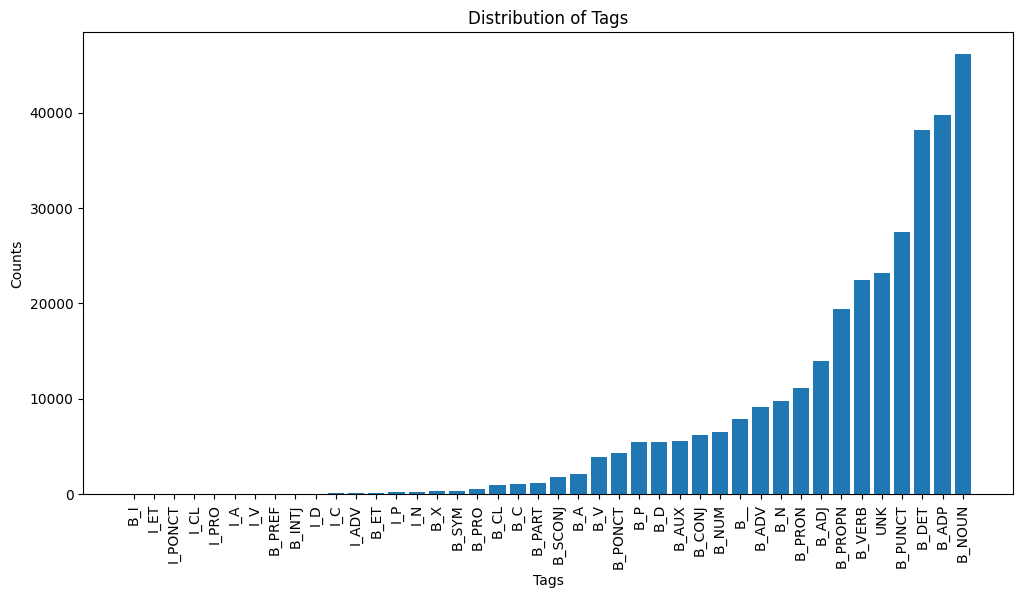

In [12]:
distribution = [(tag, freq) for tag, freq in dist_tags.items()]
distribution = sorted(distribution, key = lambda x: x[1])
print(distribution)
tags, counts = zip(*distribution)
plt.figure(figsize=(12, 6))
plt.bar(tags, counts)
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Distribution of Tags')
plt.show()

### Stats

In [2]:
print(len(toks_vocab))
print(len(tags_vocab))

NameError: name 'toks_vocab' is not defined

In [3]:
train_dataset = MWEDataset("corpus/train.conllu",  isTrain = True,  window_size = 3)
testset    = MWEDataset("corpus/test.conllu", window_size = 3)

token Vocab size 35695
token Vocab size 35695


([',', 'autorisé', 'par', 'lettres', 'patentes', "d'", 'Henri'],
 'N',
 ['ponct', 'mod', 'mod', 'obj.p', 'mod', 'dep', 'obj.p'])

## Train a MLP Model 

In [10]:
#define the hyperparameters
batch_size    = 64
window_size   =  6#left context and right context
lr            = 1e-2
device        = "cpu"
epochs        = 5
emb_size      = 64
hidden_size   = 64
nb_layers     = 2
drop_out      = 0.1

In [11]:
train_dataset = MWEDataset("corpus/train.conllu",  isTrain = True,  window_size = window_size)
testset    = MWEDataset("corpus/test.conllu", window_size = window_size)
#train_dataset.toks_vocab.write("toks.vocab")
#train_dataset.tags_vocab.write("tags.vocab")


token Vocab size 35695
token Vocab size 35695


In [12]:
model = MweClassifier(
    name         = "MLP",
    toks_vocab   = train_dataset.toks_vocab,
    tags_vocab   = train_dataset.tags_vocab, 
    deprel_vocab = train_dataset.deprel_vocab,
    window_size  = window_size,
    emb_size     = emb_size, 
    hidden_size  = hidden_size, 
    drop_out     = drop_out)

In [13]:
model.train_model(train_dataset,testset, epochs= epochs, lr=lr, batch_size = batch_size, split_train=0.8)

100%|████████████████████████████████████████| 987/987 [00:02<00:00, 451.89it/s]


Epoch 0 | Mean train loss  0.3498 |  Mean dev loss  0.2900 



100%|████████████████████████████████████████| 987/987 [00:02<00:00, 419.44it/s]


Epoch 1 | Mean train loss  0.2274 |  Mean dev loss  0.1945 



100%|████████████████████████████████████████| 987/987 [00:02<00:00, 454.83it/s]


Epoch 2 | Mean train loss  0.1833 |  Mean dev loss  0.1621 



100%|████████████████████████████████████████| 987/987 [00:02<00:00, 459.71it/s]


Epoch 3 | Mean train loss  0.1669 |  Mean dev loss  0.1561 



100%|████████████████████████████████████████| 987/987 [00:02<00:00, 423.74it/s]


Epoch 4 | Mean train loss  0.1744 |  Mean dev loss  0.1453 



100%|████████████████████████████████████████| 612/612 [00:03<00:00, 159.73it/s]

AVR: Precision 0.3495 | Recall  0.3055 |  F-score  0.3133 
Weighted: Precision 0.8804 | Recall  0.8889 |  F-score  0.8983 


In [6]:
torch.save(model.state_dict(), "mod_mlp_depl.pth")
model.toks_vocab.write("toks.vocab")
model.tags_vocab.write("tags.vocab")
model.deprel_vocab.write("deprel.vocab")

In [15]:
num_tags = len(testset.tags_vocab)
# print(num_tags)
TP = torch.zeros(num_tags)
FP = torch.zeros(num_tags)
FN = torch.zeros(num_tags)
class_counts = torch.zeros(num_tags)
with torch.no_grad():
    for X_toks, deprel, Y_gold in tqdm(testset.get_loader(batch_size=500)):
        logprobs = model.forward(X_toks,deprel)
        scores, predicted_IDs = torch.max(logprobs.data, dim=1)
         # convert tensor to np arrays
        predicted_IDs = predicted_IDs.cpu().numpy()
        Y_gold = Y_gold.cpu().numpy()
        for tag in range(num_tags):
             TP[tag] += ((predicted_IDs == tag) & (Y_gold == tag)).sum()
             FP[tag] += ((predicted_IDs == tag) & (Y_gold != tag)).sum()
             FN[tag] += ((predicted_IDs != tag) & (Y_gold == tag)).sum()
             class_counts[tag] += (Y_gold == tag).sum()

100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 49.85it/s]


In [26]:
recall = TP/(TP+FN)
precision=TP/(TP+FP)

In [17]:
sum(TP)/sum(class_counts)

tensor(0.8889)

In [27]:
f_score = 2*precision*recall/(precision+recall)

In [40]:
f_score

tensor([0.9997,    nan,    nan,    nan, 0.7021, 0.9570, 0.3698, 0.9748, 0.8869,
        0.9693, 0.7979,    nan, 1.0000, 0.0033,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan])

In [35]:
for i in range(len(class_counts)):
    tag = testset.tags_vocab.rev_lookup(idx)
    if class_counts[i] == 0:
        print(tag)

I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET
I_ET


In [39]:
class_counts[testset.tags_vocab.lookup('I_N')]

tensor(244.)

In [43]:
tags=[]
for idx in torch.nonzero(torch.gt(f_score, 0.8)).squeeze():
    tag = testset.tags_vocab.rev_lookup(idx)
    tags.append((tag, precision[idx]))
print(len(tags))
print(tags)

6
[('B_X', tensor(0.9994)), ('B_P', tensor(0.9976)), ('B_D', tensor(0.9963)), ('B_N', tensor(0.9461)), ('B_PONCT', tensor(1.)), ('B__', tensor(1.))]


In [7]:
model.save(path = ".", name = "rnn_deprel.pth")

In [7]:
num_tags = len(testset.tags_vocab)
# print(num_tags)
TP = torch.zeros(num_tags)
FP = torch.zeros(num_tags)
FN = torch.zeros(num_tags)
class_counts = torch.zeros(num_tags)
with torch.no_grad():
    for X_toks, Y_gold in tqdm(testset.get_loader()):
        logprobs = model.forward(X_toks)
        scores, predicted_IDs = torch.max(logprobs.data, dim=2)
         # convert tensor to np arrays
        predicted_IDs = predicted_IDs.cpu().numpy()
        Y_gold = Y_gold.cpu().numpy()
        for tag in range(num_tags):
             TP[tag] += ((predicted_IDs == tag) & (Y_gold == tag)).sum()
             FP[tag] += ((predicted_IDs == tag) & (Y_gold != tag)).sum()
             FN[tag] += ((predicted_IDs != tag) & (Y_gold == tag)).sum()
             class_counts[tag] += (Y_gold == tag).sum()

100%|███████████████████████████████████████| 1667/1667 [00:23<00:00, 72.15it/s]


### Calculate precision

In [8]:
precision = TP / (TP + FP)
nan_mask = torch.isnan(precision)
precision[nan_mask] = 0.
print(precision)

tensor([1.0000, 0.9629, 0.3710, 0.0000, 0.0165, 0.0000, 0.1242, 0.0000, 0.6712,
        0.0000, 0.9481, 0.0000, 0.6186, 0.9563, 0.0000, 0.9375, 0.0000, 0.9290,
        0.0000, 0.6558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4485,
        0.0000, 0.0000, 0.6512, 0.0000, 0.0000, 0.5547, 0.0000, 0.0833, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0569, 0.0153, 0.0316, 0.0801, 0.0217, 0.0390,
        0.0000, 0.0000, 0.0099, 0.0000, 0.0060, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [9]:
mask = (class_counts==0)

In [17]:
tags=[]
for idx in torch.nonzero(torch.gt(precision, 0.4)).squeeze():
    tag = testset.tags_vocab.rev_lookup(idx)
    if (tag.startswith("B") or tag.startswith("I")) and class_counts[idx]!=0:
        tags.append((tag, precision[idx]))
print(len(tags))
print(tags)

11
[('B_X', tensor(1.)), ('B_V', tensor(0.6712)), ('B_P', tensor(0.9481)), ('B_A', tensor(0.6186)), ('B_D', tensor(0.9563)), ('B_N', tensor(0.9375)), ('B_PONCT', tensor(0.9290)), ('B_C', tensor(0.6558)), ('B_PRO', tensor(0.4485)), ('B__', tensor(0.6512)), ('B_ADV', tensor(0.5547))]


In [11]:
recall =  TP / (TP + FN)
nan_mask = torch.isnan(recall)
recall[nan_mask] = 0.
print(precision)

tensor([1.0000, 0.9629, 0.3710, 0.0000, 0.0165, 0.0000, 0.1242, 0.0000, 0.6712,
        0.0000, 0.9481, 0.0000, 0.6186, 0.9563, 0.0000, 0.9375, 0.0000, 0.9290,
        0.0000, 0.6558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4485,
        0.0000, 0.0000, 0.6512, 0.0000, 0.0000, 0.5547, 0.0000, 0.0833, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0569, 0.0153, 0.0316, 0.0801, 0.0217, 0.0390,
        0.0000, 0.0000, 0.0099, 0.0000, 0.0060, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [18]:
f1_score = 2 * (precision * recall) / (precision + recall)
nan_mask = torch.isnan(f1_score)
f1_score[nan_mask] = 0.
print(f1_score)

tensor([1.0000, 0.9721, 0.0000, 0.0161, 0.0000, 0.1232, 0.0000, 0.2027, 0.0000,
        0.3271, 0.0000, 0.1895, 0.0000, 0.0000, 0.7527, 0.0000, 0.5660, 0.0000,
        0.4887, 0.0000, 0.1721, 0.3816, 0.1260, 0.0229, 0.5144, 0.0000, 0.0000,
        0.5984, 0.1346, 0.0000, 0.8020, 0.4167, 0.0000, 0.6382, 0.0000, 0.0774,
        0.2626, 0.0309, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


NameError: name 'f1_score' is not defined

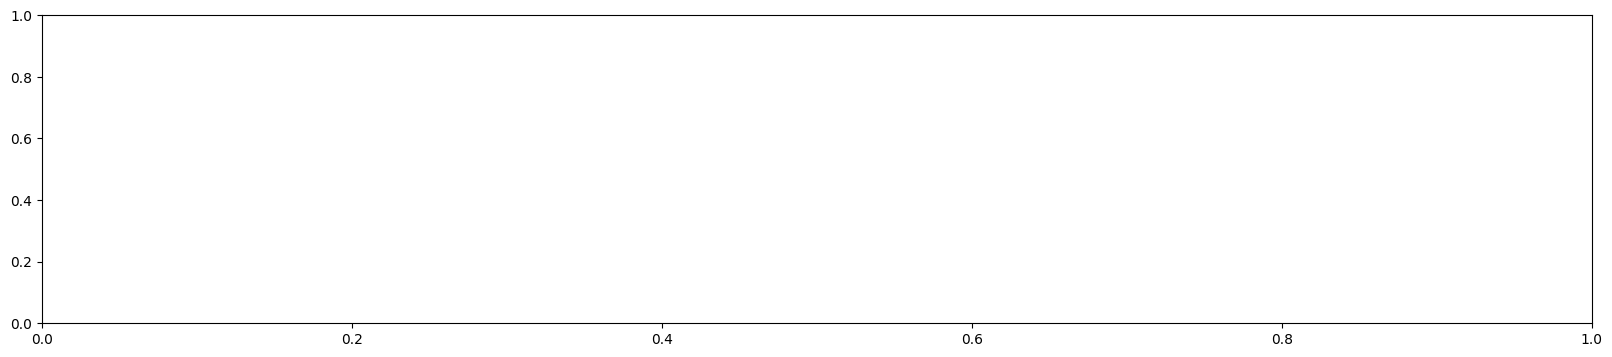

In [13]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 4))

bars = ax.bar([testset.tags_vocab.rev_lookup(i) for i in range(len(testset.tags_vocab)-50)], f1_score[:-50])


# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('f-score')
ax.set_title('f-scores for every tag annotated with the weights per frequency')

# Show the plot
plt.show()

### Scripts to save the trained model

In [19]:
model.save("attention_mod.pth")

### Scripts to load the trained model from model file

In [ ]:
model, vocab_toks, vocab_tags = MweClassifier.load("model.pth", "MLP", "toks.txt", "tags.txt", window_size = 3, embsize=64, hidden_size = 64,drop_out=0., device = "cpu")

In [189]:
testset    = MWEDataset("corpus/test.conllu", toks_vocab = vocab_toks, tags_vocab = vocab_tags, window_size = 3)

token Vocab size 35694


In [7]:
average_precision, average_recall,average_f1_score, weighted_f1_score, weighted_recall,weighted_precision  = model.evaluate(testset.get_loader(batch_size=500))

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.65it/s]
